In [33]:
!pip install pykalman
!pip install ffn

  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import datetime
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from numpy import log, polyfit, sqrt, std, subtract
import ffn
import warnings
warnings.filterwarnings('ignore')

In [2]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

df = yf.download(tickers, start, end)['Close']

[*********************100%***********************]  11 of 11 completed


In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'MSFT'), ('AMD', 'MSFT'), ('HPQ', 'ORCL'), ('ORCL', 'SPY')]


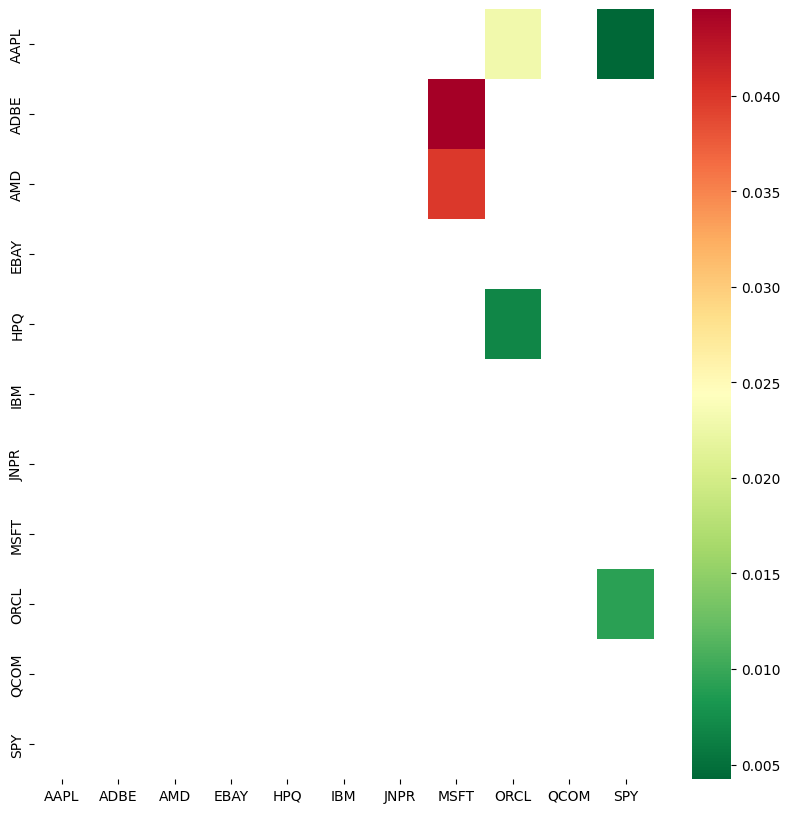

In [4]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [5]:
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means


#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [27]:
for pair in pairs:
    df[f'hedge_ratio_{pair[0]}_{pair[1]}']= -1 * KalmanFilterRegression(KalmanFilterAverage(df[pair[0]]),KalmanFilterAverage(df[pair[1]]))[:,0]

    df[f'spread_{pair[0]}_{pair[1]}'] = df[pair[1]] + df[f'hedge_ratio_{pair[0]}_{pair[1]}'] * df[pair[0]]

    halflife = half_life(df[f'spread_{pair[0]}_{pair[1]}'])

    meanSpread = df[f'spread_{pair[0]}_{pair[1]}'].rolling(window=halflife).mean()
    stdSpread = df[f'spread_{pair[0]}_{pair[1]}'].rolling(window=halflife).std()

    df[f'zScore_{pair[0]}_{pair[1]}'] = (df[f'spread_{pair[0]}_{pair[1]}']-meanSpread)/stdSpread

    df[f'volatility_{pair[0]}_{pair[1]}'] = df[f'spread_{pair[0]}_{pair[1]}'].rolling(window=20).std()

    # Define maximum capital allocation (e.g., 20% of the portfolio per trade)
    max_allocation = 0.2

    # Position size inversely proportional to volatility
    df[f'position_size_{pair[0]}_{pair[1]}'] = max_allocation / df[f'volatility_{pair[0]}_{pair[1]}']

    entryZscore = 1.5
    exitZscore = 0



    df[f'long entry_{pair[0]}_{pair[1]}'] = ((df[f'zScore_{pair[0]}_{pair[1]}'] < - entryZscore) & ( df[f'zScore_{pair[0]}_{pair[1]}'].shift(1) > - entryZscore))
    df[f'long exit_{pair[0]}_{pair[1]}'] = ((df[f'zScore_{pair[0]}_{pair[1]}'] > - exitZscore) & (df[f'zScore_{pair[0]}_{pair[1]}'].shift(1) < - exitZscore))
    df[f'num units long_{pair[0]}_{pair[1]}'] = np.nan
    df.loc[df[f'long entry_{pair[0]}_{pair[1]}'],f'num units long_{pair[0]}_{pair[1]}'] = 1 + 0*df[f'position_size_{pair[0]}_{pair[1]}']
    df.loc[df[f'long exit_{pair[0]}_{pair[1]}'],f'num units long_{pair[0]}_{pair[1]}'] = 0
    df[f'num units long_{pair[0]}_{pair[1]}'].iloc[0] = 0
    df[f'num units long_{pair[0]}_{pair[1]}'] = df[f'num units long_{pair[0]}_{pair[1]}'].fillna(method='pad')

    df[f'short entry_{pair[0]}_{pair[1]}'] = ((df[f'zScore_{pair[0]}_{pair[1]}'] >  entryZscore) & ( df[f'zScore_{pair[0]}_{pair[1]}'].shift(1) < entryZscore))
    df[f'short exit_{pair[0]}_{pair[1]}'] = ((df[f'zScore_{pair[0]}_{pair[1]}'] < exitZscore) & (df[f'zScore_{pair[0]}_{pair[1]}'].shift(1) > exitZscore))
    df.loc[df[f'short entry_{pair[0]}_{pair[1]}'],f'num units short_{pair[0]}_{pair[1]}'] = -1+0*df[f'position_size_{pair[0]}_{pair[1]}']
    df.loc[df[f'short exit_{pair[0]}_{pair[1]}'],f'num units short_{pair[0]}_{pair[1]}'] = 0
    df[f'num units short_{pair[0]}_{pair[1]}'].iloc[0] = 0
    df[f'num units short_{pair[0]}_{pair[1]}'] = df[f'num units short_{pair[0]}_{pair[1]}'].fillna(method='pad')

    df[f'numUnits_{pair[0]}_{pair[1]}'] = df[f'num units long_{pair[0]}_{pair[1]}'] + df[f'num units short_{pair[0]}_{pair[1]}']
    df[f'spread pct ch_{pair[0]}_{pair[1]}'] = (df[f'spread_{pair[0]}_{pair[1]}'] - df[f'spread_{pair[0]}_{pair[1]}'].shift(1)) / ((df[pair[0]] * abs(df[f'hedge_ratio_{pair[0]}_{pair[1]}']) + df[pair[1]]))
    df[f'port rets_{pair[0]}_{pair[1]}'] = df[f'spread pct ch_{pair[0]}_{pair[1]}'] * df[f'numUnits_{pair[0]}_{pair[1]}'].shift(1)

    df[f'cum rets_{pair[0]}_{pair[1]}'] = df[f'port rets_{pair[0]}_{pair[1]}'].cumsum()
    df[f'cum rets_{pair[0]}_{pair[1]}'] = df[f'cum rets_{pair[0]}_{pair[1]}'] + 1

    try:
        sharpe = ((df[f'port rets_{pair[0]}_{pair[1]}'].mean() / df[f'port rets_{pair[0]}_{pair[1]}'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0
    print(sharpe)


0.7190734514903827
0.9267745789195146
1.3039972553616592
1.9703914008517993
0.5354961264960392
0.7432828670299869


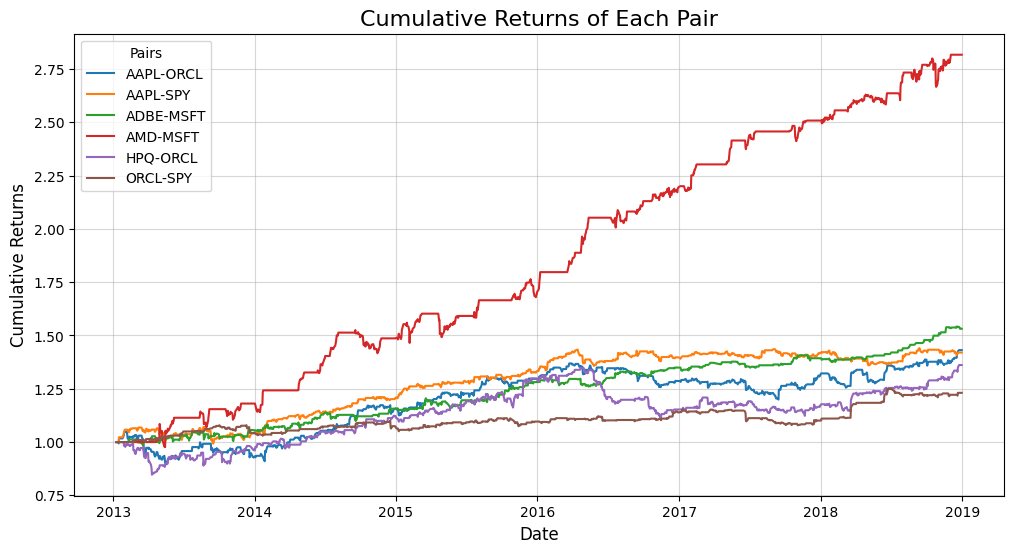

In [28]:
plt.figure(figsize=(12, 6))

for pair in pairs:
    cum_rets_col = f'cum rets_{pair[0]}_{pair[1]}'
    if cum_rets_col in df.columns:
        plt.plot(df.index, df[cum_rets_col], label=f'{pair[0]}-{pair[1]}')

plt.title("Cumulative Returns of Each Pair", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(title="Pairs", fontsize=10)
plt.grid(alpha=0.5)

plt.show()

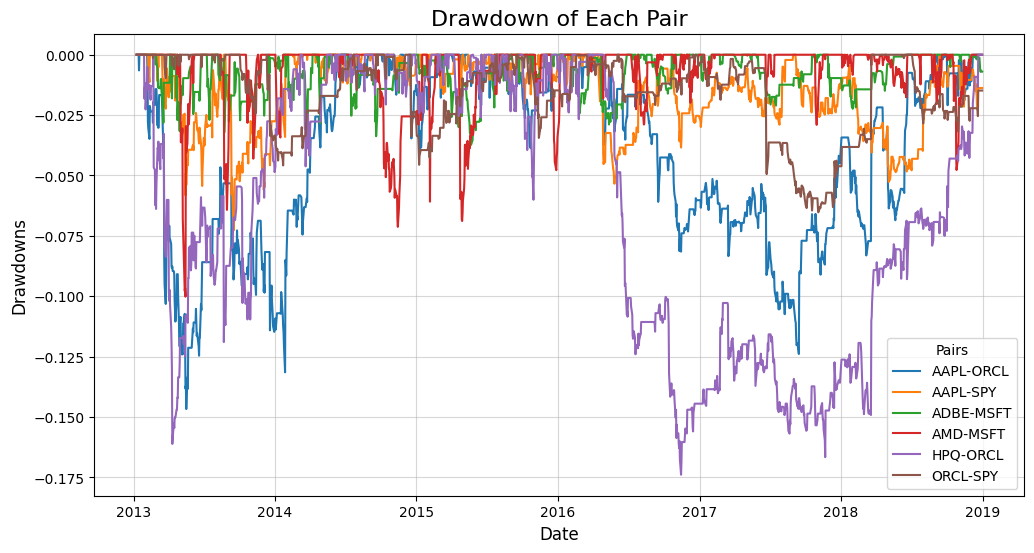

In [29]:
plt.figure(figsize=(12, 6))

for pair in pairs:
  df[f'Drawdown_{pair[0]}_{pair[1]}'] = df[f'cum rets_{pair[0]}_{pair[1]}'].to_drawdown_series()
  drawdown_col = f'Drawdown_{pair[0]}_{pair[1]}'
  if drawdown_col in df.columns:
        plt.plot(df.index, df[drawdown_col], label=f'{pair[0]}-{pair[1]}')


plt.title("Drawdown of Each Pair", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Drawdowns", fontsize=12)
plt.legend(title="Pairs", fontsize=10)
plt.grid(alpha=0.5)

plt.show()

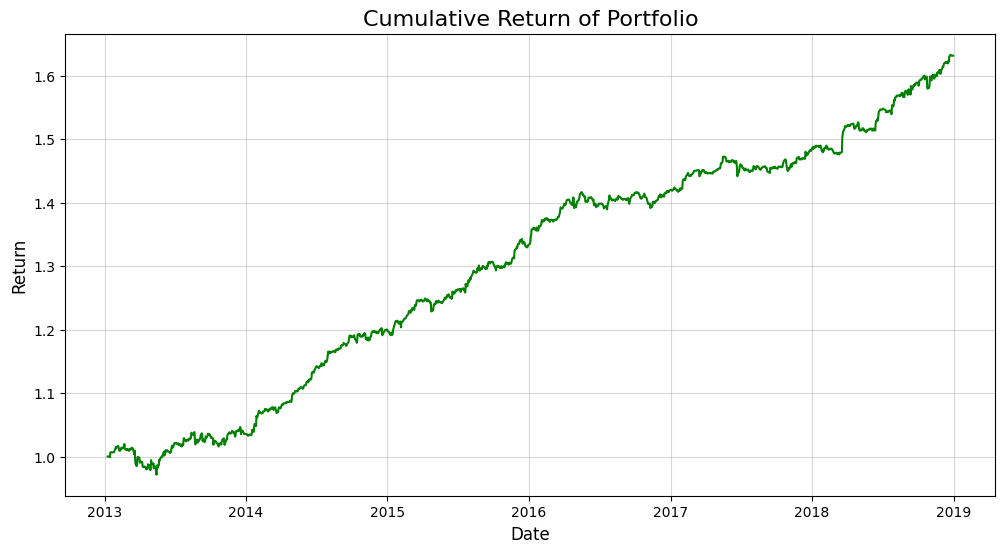

In [30]:
df['portfolio return']=0;
for pair in pairs:
  df['portfolio return']+=df[f'cum rets_{pair[0]}_{pair[1]}']/6

plt.figure(figsize=(12, 6))
plt.plot(df.index,df['portfolio return'],color='green')
plt.title("Cumulative Return of Portfolio", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Return", fontsize=12)
plt.grid(alpha=0.5)

plt.show()

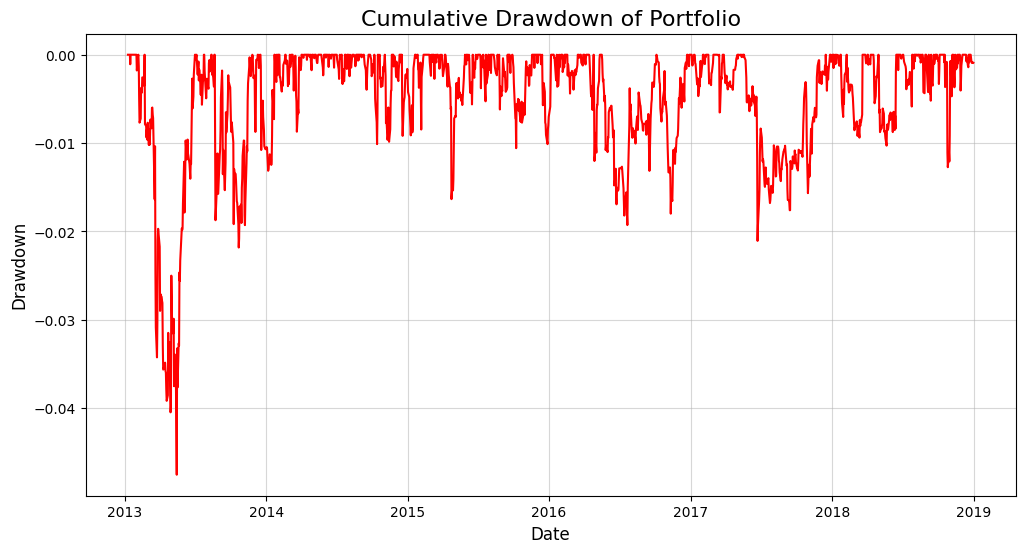

In [31]:
df['portfolio drawdown']=df['portfolio return'].to_drawdown_series()

plt.figure(figsize=(12, 6))
plt.plot(df.index,df['portfolio drawdown'], color='red')
plt.title("Cumulative Drawdown of Portfolio", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Drawdown", fontsize=12)
plt.grid(alpha=0.5)

plt.show()

In [32]:
df['daily rets'] = df['portfolio return'].pct_change()
df = df.dropna(subset=['daily rets'])

mean_daily_rets = df['daily rets'].mean()
std_daily_rets = df['daily rets'].std()

sharpe_ratio = (mean_daily_rets / std_daily_rets) * np.sqrt(252)

print("Sharpe Ratio:", sharpe_ratio)

Sharpe Ratio: 2.169217852679926
